In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = "ignore")

pd.set_option("display.max_columns" , 200)

pd.options.display.float_format = '{:.2f}'.format  
# bunun yerine her seferinde round falann da kullanılaiblir.


In [3]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

We need to separate the columns into numeric, categorical, categorical but high cardinality, numeric but categorical, the function below does this.

In [4]:
def grab_col_names( dataframe, cat_th = 10 , car_th = 20 ) :
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['object' , 'category' , 'bool']]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["int64", "float64"]]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

For the summary, let's see a slightly more customized version of the describe.

In [5]:
def ozet(df , kind = "n"):
    
    if (kind == "n") :
        df_numeric = df.select_dtypes(include=['int64', 'float64'])
        summ = pd.DataFrame(df_numeric.dtypes, columns=['data type'])

        desc = df_numeric.describe().transpose() # getting the stats
        summ['#missing'] = df_numeric.isnull().sum().values
        summ['#duplicate'] = df_numeric.duplicated().sum()
        
        summ['min'] = desc['min'].values
        summ['max'] = desc['max'].values
        summ['mean'] = desc['mean'].values
        summ["median"] = desc["50%"].values
        summ['std dev'] = desc['std'].values

    elif (kind == "c") : 
        df_categoric = df.select_dtypes(include = ['O'])
        summ = pd.DataFrame(df_categoric.dtypes, columns=['data type'])
        summ['#missing'] = df_categoric.isnull().sum().values
        summ['#duplicate'] = df_categoric.duplicated().sum()

        desc_cat = df_categoric.describe().transpose()
        summ['count'] = desc_cat['count'].values
        summ['unique'] = desc_cat['unique'].values
        summ['top'] = desc_cat['top'].values
        summ['freq'] = desc_cat['freq'].values
        summ["percentage_of_top"] = (summ['freq'] / summ['count']) *100
    

    return summ

In [6]:
def compare_frequency(df, index, columns, fill_value=0, bar_title="Bar Chart", pie_title="Pie Chart", show_pie=False):
    
    # Pivot table creation, crosstab function can also be used.
    pivot_table = df.pivot_table(
        values=None,
        index=index,
        columns=columns,
        aggfunc='size',
        fill_value=fill_value
    )
    
    # Making Charts
    plt.figure(figsize=(15, 5), dpi=150)
    
    # Bar 
    ax1 = plt.subplot(121)
    pivot_table.plot(kind='bar', ax=ax1, color=sns.color_palette('pastel'))
    ax1.set_title(bar_title)
    ax1.set_ylabel('Frequency')
    # Pie , usually pie charts are not used in data analysis but I like it.
    if show_pie:
            ax2 = plt.subplot(122)
            pivot_table.sum().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), ax=ax2)
            ax2.set_title(pie_title)
    
    plt.tight_layout()
    plt.show()

In [7]:
# url = '/kaggle/input/mobile-device-usage-and-user-behavior-dataset/user_behavior_dataset.csv'
data = pd.read_csv('user_behavior_dataset.csv')
df = data.copy()
df.head(3)

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.40,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.70,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.00,761,32,322,42,Male,2


In [8]:
df = df.drop(columns=["User ID"] , axis = 1)

In [9]:
for i in df.columns : 
    print(i)

Device Model
Operating System
App Usage Time (min/day)
Screen On Time (hours/day)
Battery Drain (mAh/day)
Number of Apps Installed
Data Usage (MB/day)
Age
Gender
User Behavior Class


In [10]:
new_cols = {
"Device Model" : "device_model",
"Operating System" : "operating_system",
"App Usage Time (min/day)" : "app_usage_time",
"Screen On Time (hours/day)" : "screen_on_time(h/day)",
"Battery Drain (mAh/day)" : "battery_drain",
"Number of Apps Installed" : "num_of_installed_apps",
"Data Usage (MB/day)" : "data_usage(mb/day)",
"Age" :  "age",
"Gender" : "gender",
"User Behavior Class" : "user_behavior_class" 
}

df.rename(columns=new_cols, inplace=True)

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 700
Variables: 10
cat_cols: 4
num_cols: 6
cat_but_car: 0
num_but_cat: 1


Aşağıdaki kod inanılmaz güzel özet veriyor :)

In [12]:
ozet(df , kind = "c")

,data type,#missing,#duplicate,count,unique,top,freq,percentage_of_top
device_model,object,0,690,700,5,Xiaomi Mi 11,146,20.86
operating_system,object,0,690,700,2,Android,554,79.14
gender,object,0,690,700,2,Male,364,52.00


In [13]:
ozet(df)

,data type,#missing,#duplicate,min,max,mean,median,std dev
app_usage_time,int64,0,0,30.00,598.00,271.13,227.50,177.20
screen_on_time(h/day),float64,0,0,1.00,12.00,5.27,4.90,3.07
battery_drain,int64,0,0,302.00,2993.00,1525.16,1502.50,819.14
num_of_installed_apps,int64,0,0,10.00,99.00,50.68,49.00,26.94
data_usage(mb/day),int64,0,0,102.00,2497.00,929.74,823.50,640.45
age,int64,0,0,18.00,59.00,38.48,38.00,12.01
user_behavior_class,int64,0,0,1.00,5.00,2.99,3.00,1.40


In [14]:
# def summarize(df):
#     summ = pd.DataFrame(df.dtypes, columns=['data type'])
#     summ['#unique'] = df.nunique().values
#     summ['#missing'] = df.isnull().sum().values
#     summ['#duplicate'] = df.duplicated().sum()
#     desc = pd.DataFrame(df.describe(include='all').transpose()) # getting the stats
    
#     summ['min'] = desc['min'].values
#     summ['max'] = desc['max'].values
#     summ['mean'] = desc['mean'].values
#     summ['std dev'] = desc['std'].values
#     summ['top value'] = desc['top'].values
#     summ['Freq'] = desc['freq'].values
#     return summ

# # formatting parameters for the sake of better representation
# cell_hover = { 
#     'selector': 'td:hover',
#     'props': [('background-color', '#ffffb3')]
# }
# index_names = {
#     'selector': '.index_name',
#     'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
# }
# headers = {
#     'selector': 'th:not(.index_name)',
#     'props': 'background-color: #2e0478; color: white;'
# }

# # summarizing the basic properties of dataset
# summarize(data).style.set_table_styles([cell_hover, index_names, headers]).background_gradient(cmap='Purples').set_caption('Raw data statistics')

**Coefficient of Variation**

To see the variation of the variables in the dataset, we will look at the coefficients of variation. The coefficient of variation (CV) is a statistical measure that measures the variation of a variable as the ratio of its standard deviation to its mean. It is usually expressed as a percentage (%).

Generally, with the coefficient of variation, we can see how homogeneous or heterogeneous the distribution of the data is, and the general levels of variation between the variables. Data with high coefficient of variation show more spread around the mean and contain more risk or uncertainty.

In [15]:
coefficient_of_variation = df.std(numeric_only=True) / df.mean(numeric_only=True)
print(coefficient_of_variation*100)

app_usage_time          65.36
screen_on_time(h/day)   58.20
battery_drain           53.71
num_of_installed_apps   53.16
data_usage(mb/day)      68.88
age                     31.22
user_behavior_class     46.87
dtype: float64


<Axes: >

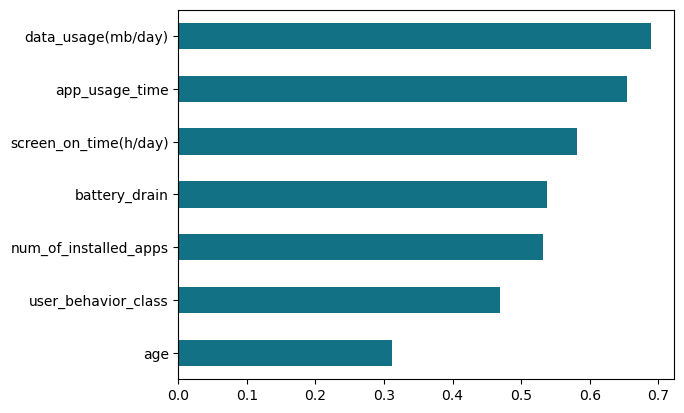

In [16]:
sorted_cv = coefficient_of_variation.sort_values()
sorted_cv.plot.barh(x = 'Variables', y = 'Coefficient of Variation', color = '#127184')

We need to examine the parts where users differ from each other so that we can classify them.

Here app_usage_time and screen_on_time(h/day) columns are the most scattered properties when examining range and std.

The battey_drain property is probably inversely proportional to the usage properties, and at first glance we can think that there might be a correlation between the data_usage property and the app_useage_time property.


With categorical data, we can get an idea of how biased the data might be by looking at the percentage of the dominant.


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_model           700 non-null    object 
 1   operating_system       700 non-null    object 
 2   app_usage_time         700 non-null    int64  
 3   screen_on_time(h/day)  700 non-null    float64
 4   battery_drain          700 non-null    int64  
 5   num_of_installed_apps  700 non-null    int64  
 6   data_usage(mb/day)     700 non-null    int64  
 7   age                    700 non-null    int64  
 8   gender                 700 non-null    object 
 9   user_behavior_class    700 non-null    int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 54.8+ KB


**EDA**

In [18]:
num_cols

['app_usage_time',
 'screen_on_time(h/day)',
 'battery_drain',
 'num_of_installed_apps',
 'data_usage(mb/day)',
 'age']

In [19]:
for i, col in enumerate(num_cols):
    print(col)

app_usage_time
screen_on_time(h/day)
battery_drain
num_of_installed_apps
data_usage(mb/day)
age


**Univariate Analysis**

In [20]:
# Calculate number of rows and columns for subplots

num_rows_num = (len(num_cols) + 2) // 3  
num_rows_cat = (len(cat_cols) + 2) // 3

# Create subplots: one for numerical and one for categorical data
fig = make_subplots(
    rows = num_rows_num + num_rows_cat, cols=3, 
    subplot_titles=[f"{col}" for col in num_cols] + 
                   [f"{col}" for col in cat_cols],
    column_widths=[0.33, 0.33, 0.33]  # Evenly distribute the width across 3 columns
)


# Add histograms for numerical columns
for i, col in enumerate(num_cols):
    row_in_subplot = (i // 3) + 1 
    col_in_subplot = (i % 3) + 1  
    fig.add_trace(
        go.Histogram(x=df[col], name=col, opacity=0.75),
        row=row_in_subplot, col=col_in_subplot
    )

# Add barplot for categorical columns (count of each category)
for i, col in enumerate(cat_cols):
    row_in_subplot = num_rows_num + (i // 3) + 1  
    col_in_subplot = (i % 3) + 1  
    
    # Ensure there's data in the column
    if df[col].notna().sum() > 0:
        fig.add_trace(
            go.Histogram(x=df[col], name=col, histfunc='count', opacity=0.75),
            row = row_in_subplot, col = col_in_subplot
        )

# Update layout with increased height and better spacing
fig.update_layout(
    title="Histograms of Numerical and Categorical Data",
    barmode='overlay',
    showlegend=False,
    height=600 + (num_rows_num * 250) + (num_rows_cat * 250),  # Adjust height based on number of rows
    width=1000,  # Increased width to accommodate 3 columns
    bargap=0.1,  # Space between bars
    title_x=0.5,  # Center title
    plot_bgcolor='white',  # White background for the entire plot
    paper_bgcolor='white',  # White background for the paper as well
    hovermode="x unified",  # Unified hovermode for better interaction
    title_font=dict(size=20)
)

# Show the plot
fig.show(renderer='iframe_connected')

* **make_subplots**  : belirtilen satır ve sütun sayısına göre bir subplot grid'i oluşturur.
* rows = Topla satır sayısı.
* cols = toplam sütun sayısı
* subplot_titles  = grafik başlıkları
* columns_widths = Her sütunun genişliği


Numeric sütunlar için Histogram veya kdeplot kullanılabilir.
kategorik sütunlar için de barplot kullanılması güzel olacaktır.

kategorik değişkenelerden operating_system için dominantlık konusunda daha önce de bir değişiklik görmüştük sayısal olarak , bunu görselleştirdik.
kalan kategorik değişkenlerin dağılımının neredeyse homojen olduğu söylenebilir belki de.

Operaitng_System değişkenini olduğu gibi ele almak biraz yanlış olaiblir çünkü IOS kullanan kişiler sadece tek bir device_model türüne sahipken kalan device_modellerin hepsi android kullanıyor. Burada normalleştirme mantıklı bir seçim olacaktır.

İşletim sistemi değişkenini kullanılan telefon modellerinin frekansına bölersek(örneğin android kullanan 4 telefon modeli varsa datada android/4 gibi) daha anlamlı bir özellik elde ederiz gibi gözüküyor.



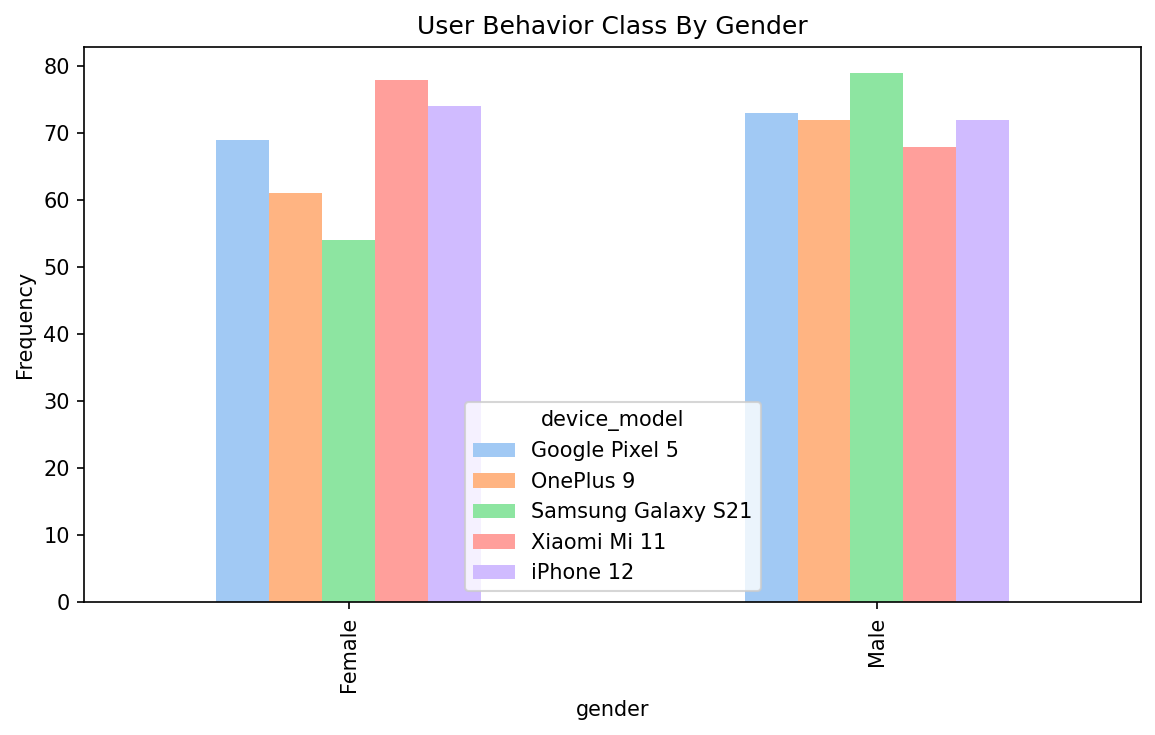

In [21]:
compare_frequency(
    df = df,
    index='gender',
    columns='device_model', # Bu sütun tek başına da incelenecektir.
    fill_value=0,
    bar_title='User Behavior Class By Gender',
    pie_title='Operating System Distribution',
    show_pie=False
)

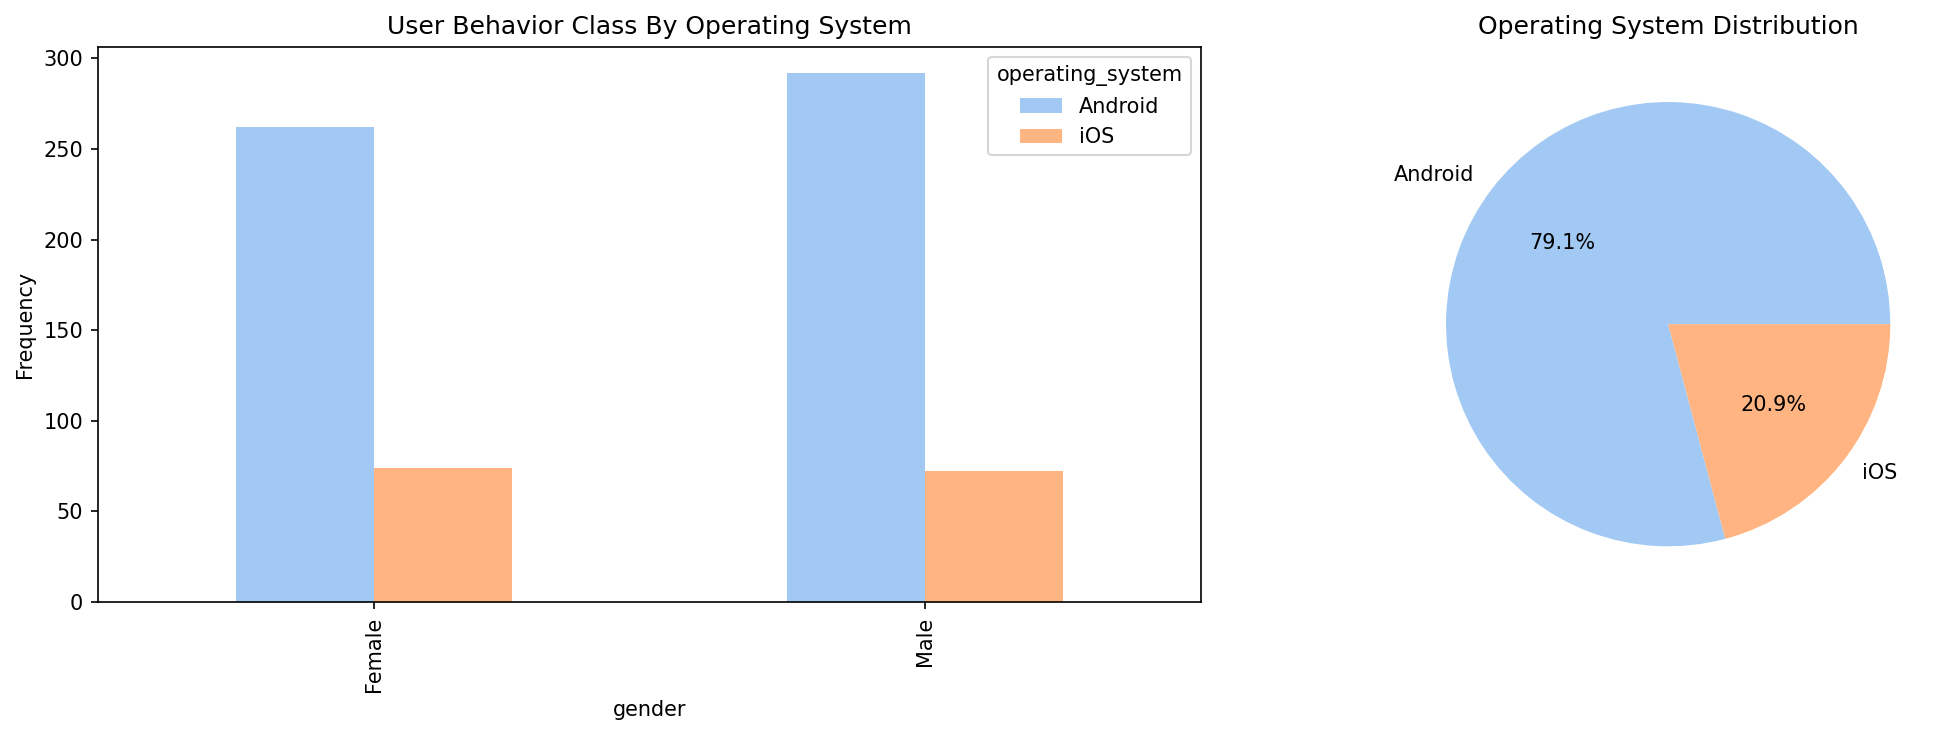

In [22]:
compare_frequency(
    df = df,
    index='gender',
    columns='operating_system', # Bu sütun tek başına da incelenecektir.
    fill_value=0,
    bar_title='User Behavior Class By Operating System',
    pie_title='Operating System Distribution',
    show_pie=True
)

In [23]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
    
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Eğer baskılama yntemini kullancaksak aşağıdaki fonksiyon oyuna girer.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [24]:
for column in num_cols: 
    # Plot boxplot if there are outliers
    if check_outlier(df,column) :
        fig = px.box(df, y=column, title=f'Boxplot of {column} with Outliers')
        fig.show()
        
    else:
        print(f"{column} has : no outliers\n")


app_usage_time has : no outliers

screen_on_time(h/day) has : no outliers

battery_drain has : no outliers

num_of_installed_apps has : no outliers

data_usage(mb/day) has : no outliers

age has : no outliers



There are no outliers in the data we have!

It is probably a manually collected data so it is not surprising.

There are no missing values, there are no duplicate records, we are dealing with a clean data set.

## Let's Try to Derive New Features

For example, we can determine the relationship between screen time and battery drain by dividing the two. This way, we can see how much battery is consumed while the screen is on.

If we learn the battery capacity of each phone model, and then obtain the average battery consumption, we can estimate how many hours the phone will stay on. Of course, we will consider how much the battery is drained each hour the screen is on, which will cause it to look like the battery consumption is the same every hour the screen is on. This is an assumption, of course, and it might be reconsidered, but it doesn't seem that important.

Since we have the battery capacity and battery consumption values, we can also find out how many times the battery will drain in a full day.

In [25]:
capacity = {'Google Pixel 5': 4080, 'OnePlus 9': 4500, 
            'Xiaomi Mi 11': 4600, 'iPhone 12': 2815, 'Samsung Galaxy S21':4000}
# reference: https://m.gsmarena.com/


df['capacity'] = data['Device Model'].apply(lambda x: capacity[x] if x in capacity else 'NaN')
df['avg_power_consumption'] = df['battery_drain']/df['screen_on_time(h/day)']

df['Battery_life'] = df['capacity']/df['avg_power_consumption']
df[df['Battery_life'] < df['screen_on_time(h/day)']]
df['cycle_number_per_day'] = df['battery_drain']/df['capacity']
df

,device_model,operating_system,app_usage_time,screen_on_time(h/day),battery_drain,num_of_installed_apps,data_usage(mb/day),age,gender,user_behavior_class,capacity,avg_power_consumption,Battery_life,cycle_number_per_day
0,Google Pixel 5,Android,393,6.40,1872,67,1122,40,Male,4,4080,292.50,13.95,0.46
1,OnePlus 9,Android,268,4.70,1331,42,944,47,Female,3,4500,283.19,15.89,0.30
2,Xiaomi Mi 11,Android,154,4.00,761,32,322,42,Male,2,4600,190.25,24.18,0.17
3,Google Pixel 5,Android,239,4.80,1676,56,871,20,Male,3,4080,349.17,11.68,0.41
4,iPhone 12,iOS,187,4.30,1367,58,988,31,Female,3,2815,317.91,8.85,0.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,iPhone 12,iOS,92,3.90,1082,26,381,22,Male,2,2815,277.44,10.15,0.38
696,Xiaomi Mi 11,Android,316,6.80,1965,68,1201,59,Male,4,4600,288.97,15.92,0.43
697,Google Pixel 5,Android,99,3.10,942,22,457,50,Female,2,4080,303.87,13.43,0.23
698,Samsung Galaxy S21,Android,62,1.70,431,13,224,44,Male,1,4000,253.53,15.78,0.11


The following part comes from a research that has been used a lot in studies on this notebook, I am adding it because I find it interesting.

In [26]:
df['cycle_number_in_400days'] = df['cycle_number_per_day']* 400

In [27]:
df.sample()

,device_model,operating_system,app_usage_time,screen_on_time(h/day),battery_drain,num_of_installed_apps,data_usage(mb/day),age,gender,user_behavior_class,capacity,avg_power_consumption,Battery_life,cycle_number_per_day,cycle_number_in_400days
147,Xiaomi Mi 11,Android,52,1.60,385,19,234,24,Male,1,4600,240.62,19.12,0.08,33.48


In [28]:
fig = px.scatter(df, x='capacity', y='cycle_number_in_400days',
                 color='device_model', size='screen_on_time(h/day)')


fig.add_shape(type="line",
              x0=df['capacity'].min()-500, x1=df['capacity'].max()+500,  # Extend the line across the plot
              y0=400, y1=400,  # Position the line at y = 400
              line=dict(color="red", width=2, dash="dash"),
              name="Threshold at 400")

# Update layout with increased height and better spacing
fig.update_layout(
    title="Battery health degradation",
    plot_bgcolor='white',  # White background for the entire plot
    paper_bgcolor='white',  # White background for the paper as well
    hovermode="y unified",  # Unified hovermode for better interaction
    title_font=dict(size=20))

fig.show(renderer='iframe_connected')

In [29]:
num_cols.extend(['cycle_number_per_day' ,'Battery_life','avg_power_consumption', 'capacity'])

# Multivariate Analysis



In [30]:
# sns.pairplot(data = df,vars=num_cols, hue='user_behavior_class') 
# Burada incelemek istediğin sütunları bırak sadece

# fig = plt.figure(figsize=(12,6))
# mask = np.zeros_like(df[num_cols].corr(numeric_only=True))
# mask[np.triu_indices_from(mask)] = True


# f, ax = plt.subplots(figsize=(10, 10))
# sns.heatmap(df[num_cols].corr(numeric_only=True), annot=True, fmt='.2f',
#             vmin=-1, vmax=1,
#             ax=ax, cmap='coolwarm', mask=mask)
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.title('Heat Map', size=14)
# plt.show()

In fact, the variables with high correlation with the User Behavior Class variable are directly revealed, except for the age feature, other features fit into a certain pattern, this is a good thing of course :)

# Classification / Model Construct

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder # 

    
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import RandomizedSearchCV

In [32]:
def evaluate_classification(model, test_features, test_labels):
    predictions = model.predict(test_features)  # Modelin tahminlerini al  
    
    # Performans hesaplıyoruz.
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average='weighted')  # Weighted için sınıf dengesi
    recall = recall_score(test_labels, predictions, average='weighted')
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    
    print(f"\nModel Performance for {type(model).__name__}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    # bir sözlük şeklinde tüm skorları da döndürebilir ama benim amacım sadece yazdımak.
    return accuracy

In [33]:
X = df.drop(columns = ["user_behavior_class"] , axis = 1)
y = df["user_behavior_class"]

In [34]:
# Eğer cat_cols listesinden user_behavior_class ı çıkarırsan 
# aşağıdaki koda fazla gerek kalmıyor aslında ama standart işlem olsun.
cat_cols = X.select_dtypes(include=['object']).columns.values
num_cols = X.select_dtypes(include=np.number).columns.tolist()

In [35]:
# Data Preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

**Applying Standard Scaler for numerical data and OneHotEncoder for categorical data**

**1. ColumnTransformer:**

The `ColumnTransformer` is used to apply different preprocessing steps to columns with different data types.

* **`transformers` parameter**: This defines a list where each element specifies which transformation to apply to which columns.

    * In the first element **("num", StandardScaler(), num_cols)**:
        * **"num"**: This is a name given to the transformer for identification.
        * **`StandardScaler()`**: Scales numerical columns (`num_cols`) so that they have a mean of 0 and a variance of 1.
        * **`num_cols`**: Specifies the columns to which the transformer will be applied (numerical columns).
    
    * In the second element **("cat", OneHotEncoder(drop='first'), cat_cols)**:
        * **"cat"**: This is a name given to the transformer for identification.
        * **`OneHotEncoder(drop='first')`**: Transforms categorical columns (`cat_cols`) using one-hot encoding. The `drop='first'` parameter drops the first category, reducing dimensionality.
        * **`cat_cols`**: Specifies the columns to which the transformer will be applied (categorical columns).

---

**2. Pipeline:**

The `Pipeline` function combines multiple data processing steps into a single, unified process. In your code, it combines the data preprocessing step defined by the `ColumnTransformer` with the classifier of your choice to create a machine learning model.

* **`steps` parameter**: This defines a list where steps are added in sequence.
    * **In the first step ("preprocessor", preprocessor):**
        * `"preprocessor"`: A name for this step.
        * `preprocessor`: The `ColumnTransformer` object defined earlier.
    * **In the second step ("classifier", clf):**
        * `"classifier"`: A name for this step.
        * `clf`: Represents the classifier you select from the `classifiers` dictionary (e.g., `RandomForestClassifier`).

The `Pipeline` first preprocesses the data using the `ColumnTransformer` and then trains the classifier to make predictions. This approach makes your code more organized and readable.

---

**Summary:**

* `ColumnTransformer` allows you to apply different preprocessing steps based on data types.
* `Pipeline` integrates multiple preprocessing and modeling steps into a single streamlined process, keeping your code cleaner and easier to manage.

In [36]:
# Models
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=200),
    'SVM': SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'KNeighbors': KNeighborsClassifier()
}


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

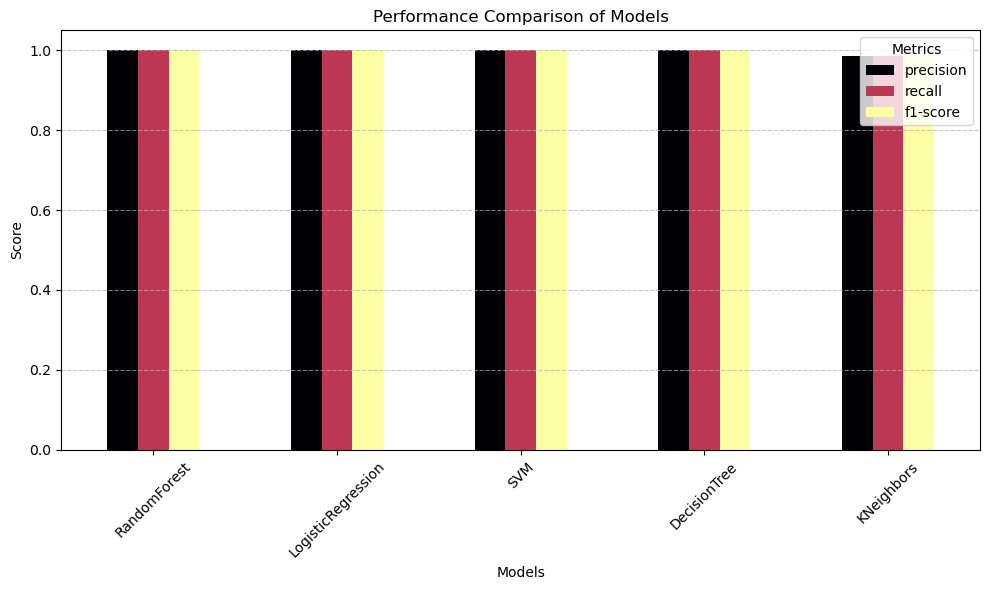

                    precision  recall  f1-score
RandomForest             1.00    1.00      1.00
LogisticRegression       1.00    1.00      1.00
SVM                      1.00    1.00      1.00
DecisionTree             1.00    1.00      1.00
KNeighbors               0.99    0.99      0.99


In [38]:
# Model Training and Model evaluation

# Sonuçları kaydetmek için sözlük oluşturuyoruz.
scores = {'precision': {}, 'recall': {}, 'f1-score': {}}


for name, clf in classifiers.items():
    model = Pipeline(
        steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Test
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Macro avg değerlerini kaydet
    scores['precision'][name] = report['macro avg']['precision']
    scores['recall'][name] = report['macro avg']['recall']
    scores['f1-score'][name] = report['macro avg']['f1-score']

    # Sözlüğü DataFrame'e dönüştür
    scores_df = pd.DataFrame(scores)

# Bar Grafik Çizimi
scores_df.plot(kind='bar', figsize=(10, 6), colormap='inferno')# Germany:)
plt.title("Performance Comparison of Models")
plt.ylabel("Score")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(scores_df)

Let's assume that we use RandomForest in particular. We use it in combination with hyperparameter optimization.

In [39]:
# Pipeline oluştur: önce ön işleme, sonra model
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),  # Veri ön işleme
        ('classifier', RandomForestClassifier(random_state=42))  # Model
    ])

In [40]:

# The values I want to be checked, usually this part is done with ChatGPT :)
param_distributions = {
    'classifier__n_estimators': [50, 100, 200, 300],  # Pipeline'da "classifier" adımına ait parametre , # Ağaç sayısı
    'classifier__max_depth': [None, 10, 20, 30, 50],   # Maksimum derinlik
    'classifier__min_samples_split': [2, 5, 10],        # Dallanma için minimum örnek
    'classifier__min_samples_leaf': [1, 2, 4],           # Yaprakta minimum örnek
    'classifier__bootstrap': [True, False]                # Bootstrap örneklemesi
}

# Creating RondomSearch object 
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,  # 50 rastgele kombinasyon deniyor
    scoring='accuracy', #sonuçları accuracy metriğiyle ölçüyor.
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralel işlem
)



random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['app_usage_time',
                                                                                'screen_on_time(h/day)',
                                                                                'battery_drain',
                                                                                'num_of_installed_apps',
                                                                                'data_usage(mb/day)',
                                                                                'age',
                                                                                'capacity',
                                                                                'avg_power_consumption',
                                                                                'Battery_life',
                                                                                'cycle_number_per_day',
                                                                                'cycle_number_in_400days']),
                                                                              ('cat',
                                                                               OneHotEncod...
                                                                               array(['device_model', 'operating_system', 'gender'], dtype=object))])),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [None, 10, 20,
                                                                  30, 50],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [50, 100,
                                                                     200,
                                                                     300]},
                   random_state=42, scoring='accuracy', verbose=2)

In [41]:
# Best parameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# best model
final_model = random_search.best_estimator_


final_model.fit(X_train, y_train)

Best Hyperparameters: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10, 'classifier__bootstrap': False}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['app_usage_time',
                                                   'screen_on_time(h/day)',
                                                   'battery_drain',
                                                   'num_of_installed_apps',
                                                   'data_usage(mb/day)', 'age',
                                                   'capacity',
                                                   'avg_power_consumption',
                                                   'Battery_life',
                                                   'cycle_number_per_day',
                                                   'cycle_number_in_400days']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  array(['device_model', 'operating_system', 'gender'], dtype=object))])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        min_samples_split=10, n_estimators=50,
                                        random_state=42))])

In [42]:
evaluate_classification(final_model, X_test, y_test) #evaluating the best model


Model Performance for Pipeline
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


1.0